In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from sklearn.linear_model import LinearRegression

import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy import stats
from scipy.signal import periodogram
from datetime import timedelta

In [65]:
# Import kelp dataset
kelp = pd.read_csv('Kelp/kelp_data_sorted.csv')
kelp.Date = pd.to_datetime(kelp.Date)

In [66]:
# Calculate latitude and longitude
def find_coords(lat1, lon1, heading, dist):
    R = 6378100 # Radius of the Earth in meters
    Ad = dist/R # Angular distance of point b
    lat1 = lat1 * (np.pi/180)
    lon1 = lon1 * (np.pi/180)
    theta = heading * (np.pi/180) # The bearing towards point b in radians
    
    #lat2 = np.arcsin((np.sin(lat1) * np.cos(Ad)) + (np.cos(lat1)*np.sin(Ad)*np.cos(theta)))
    lat2 = np.arcsin(np.sin(lat1) * np.cos(Ad) + np.cos(lat1) * np.sin(Ad) * np.cos(theta)) * (180/np.pi)
    lon2 = (lon1 + np.arctan2(np.sin(theta) * np.sin(Ad) * np.cos(lat1), np.cos(Ad) - np.sin(lat1) * np.sin(lat2))) * (180/np.pi)
    return lat2, lon2

In [67]:
lat1 = 36.56196
lon1 = -121.94176

lat2, lon2 = find_coords(lat1, lon1, kelp.Heading, kelp.Distance)

kelp['Latitude'] = lat2
kelp['Longitude'] = lon2
kelp

,Date,Heading,Distance,Diameter,Notes,Latitude,Longitude
0,2022-07-26,0,3.50,0.954930,NaN,36.561991,-121.941760
1,2022-07-26,0,4.00,1.591549,NaN,36.561996,-121.941760
2,2022-07-26,45,4.20,11.140846,NaN,36.561987,-121.941746
3,2022-07-26,45,4.60,1.909859,NaN,36.561989,-121.941745
4,2022-07-26,45,4.70,1.273240,NaN,36.561990,-121.941744
...,...,...,...,...,...,...,...
227,2022-08-30,270,7.50,7.100000,NaN,36.561960,-121.941795
228,2022-08-30,315,3.50,3.300000,NaN,36.561982,-121.941772
229,2022-08-30,315,5.80,4.100000,NaN,36.561997,-121.941779
230,2022-08-30,315,6.60,2.500000,NaN,36.562002,-121.941782


In [128]:
kelp.to_csv('Kelp/kelp_data.csv')

In [110]:
adcp1_lat, adcp1_lon = find_coords(lat1, lon1, 175, 2)
adv_lat, adv_lon = find_coords(lat1, lon1, 90, 4)

kelp_w1 = kelp.loc[kelp.Date.dt.day == 26, :]
kelp_w2 = kelp.loc[kelp.Date.dt.day == 1, :]
kelp_w3 = kelp.loc[kelp.Date.dt.day == 11, :]

# adcp location is different during these last surveys
adcp2_lat, adcp2_lon = find_coords(lat1, lon1, 230, 1.75)
kelp_w4 = kelp.loc[kelp.Date.dt.day == 25, :]
kelp_w5 = kelp.loc[kelp.Date.dt.day == 30, :]

Text(0.5, 1.0, 'Stipe Bundle Map')

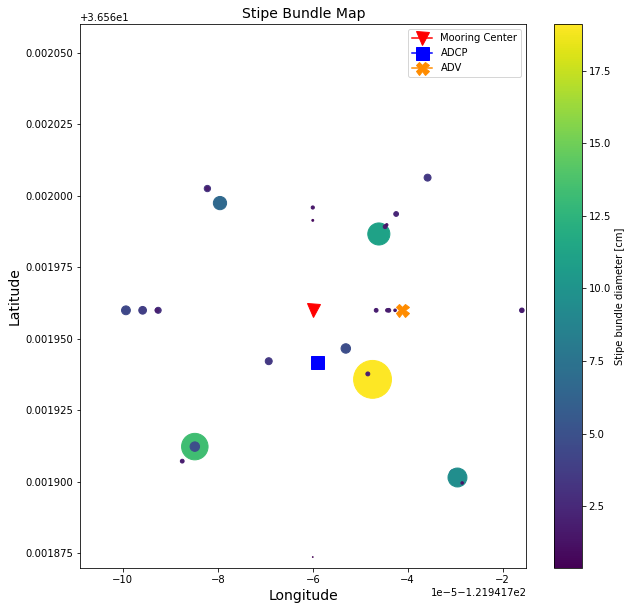

In [126]:
#survey_dates[0:3]
data = kelp_w1

plt.figure(figsize = (10,10))

plt.scatter(data.Longitude, data.Latitude, s=5*(np.pi*((data.Diameter/2)**2)), c = data.Diameter)
plt.plot(lon1, lat1, marker = "v", ms = 13, color = 'red', label = 'Mooring Center')
plt.plot(adcp1_lon, adcp1_lat, marker = "s", ms = 13, color = 'blue', label = 'ADCP')
#plt.plot(adcp2_lon, adcp2_lat, marker = "s", ms = 13, color = 'blue', label = 'ADCP')
plt.plot(adv_lon, adv_lat, marker = "X", ms = 13, color = 'darkorange', label = 'ADV')
plt.colorbar(label = 'Stipe bundle diameter [cm]')

plt.legend()

plt.ylim(36.56187,36.56206)
plt.xlim(-121.941809,-121.941715)
plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)
plt.title('Stipe Bundle Map', fontsize = 14)

#plt.savefig('Plots/Dep1_kelp_current_histograms')

In [ ]:
tmean = temp.mean() # 12.29
kv = .000001225 # kv found on https://www.omnicalculator.com/physics/water-viscosity
Re = 1000 # Re number where turbulence is observed
Vmean = adv.Magnitude.mean() # .0343 m/s

# Re = Vmean * diameter / kv, diameter = Re * kv/ Vmean
diam = ((Re * kv)/Vmean)

In [ ]:
# Above data coincides with weeks 2 and 3
# survey_dates[1:3]
kelp_diam_w1_3 = kelp_diam_w2_3.append(kelp_diam_w1)

In [ ]:
#survey_dates[0:3]
#kelp_diam_w1_3.stack()
plt.figure(figsize = (20,8))

plt.subplot(131)
plt.hist(kelp_diam_w1_3.stack()/100, bins =20, color = 'goldenrod')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Diameter (m)', fontsize = 14)
plt.title('Cumulative Stipe Bundle Diameters', fontsize = 14)

plt.subplot(132)
plt.hist(adv01_1min.Magnitude, bins=50, color = 'blue')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Current velocity (m/s)', fontsize = 14)
plt.title('Horizontal Current Velocity: SWC ADV', fontsize = 14)

plt.subplot(133)
plt.hist(adcp01.Magnitude.isel(BinDist = 1), bins=50, color = 'cyan')
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Current velocity (m/s)', fontsize = 14)
plt.title('Horizontal Current Velocity: SWC ADCP', fontsize = 14)

plt.savefig('Plots/Dep1_kelp_current_histograms')

In [ ]:
# Import kelp survey data
kelp = pd.read_csv('Kelp/kelp_data_noLR.csv')

kelp_diam_w1 = kelp_diam.iloc[0:8,:]
w1_mean = kelp_diam_w1.stack().mean()
w1_max = kelp_diam_w1.stack().max()
w1_min = kelp_diam_w1.stack().min()

kelp_diam_w2 = kelp_diam.iloc[8:18,:]
w2_mean = kelp_diam_w2.stack().mean()
w2_max = kelp_diam_w2.stack().max()
w2_min = kelp_diam_w2.stack().min()

kelp_diam_w3 = kelp_diam.iloc[18:33,:]
w3_mean = kelp_diam_w3.stack().mean()
w3_max = kelp_diam_w3.stack().max()
w3_min = kelp_diam_w3.stack().min()

kelp_diam_w4 = kelp_diam.iloc[33:48,:]
w4_mean = kelp_diam_w4.stack().mean()
w4_max = kelp_diam_w4.stack().max()
w4_min = kelp_diam_w4.stack().min()

kelp_diam_w5 = kelp_diam.iloc[48:,:]
w5_mean = kelp_diam_w5.stack().mean()
w5_max = kelp_diam_w5.stack().max()
w5_min = kelp_diam_w5.stack().min()

density_w1 = kelp_diam_w1.count().sum() / 286.28
density_w2 = kelp_diam_w2.count().sum() / 286.28
density_w3 = kelp_diam_w3.count().sum() / 286.28
density_w4 = kelp_diam_w4.count().sum() / 286.28
density_w5 = kelp_diam_w5.count().sum() / 286.28
density_arr = [density_w1, density_w2, density_w3, density_w4, density_w5]

kelp_mean_arr = np.array([w1_mean, w2_mean, w3_mean, w4_mean, w5_mean])
kelp_max_arr = np.array([w1_max, w2_max, w3_max, w4_max, w5_max])
kelp_min_arr = np.array([w1_min, w2_min, w3_min, w4_min, w5_min])

kelp['Date'] = pd.to_datetime(kelp['Date'])
survey_dates = np.unique(kelp['Date'])

In [ ]:
fig,ax = plt.subplots(figsize = (20, 8))

ax.plot(survey_dates, kelp_mean_arr/100, '-k', lw = 4, label= 'Mean Diameter')
ax.plot(survey_dates, kelp_max_arr/100, '-b', lw = 4, label = 'Max Diameter')

ax2=ax.twinx()
ax2.plot(survey_dates, density_arr, '-g', marker = 'o', ms = 10, label = 'Stipe Bundle Density')

ax.legend(loc=1, bbox_to_anchor=(.965,.95))
ax2.legend(bbox_to_anchor=(.99,1))
ax.set_ylabel('Stipe bundle diameter (m)', fontsize = 14)
ax2.set_ylabel('Stipe Bundle Density (Bundles/m\u00b2)', fontsize = 14)
ax.set_xlabel('Datetime', fontsize = 14)
plt.title('Weekly Stipe Bundle Diameter and Density (N = 5)', fontsize = 14)
plt.margins(x=.01, y = 1)

